# Data Processing and Beamforming Example

In this exercise, we first come up with an ideal synthetic test to show how to perform beamforming. Then we show an real case example to beamforming the signal of a real earthquake. From the beamforming resuts, one can get the slowness vector of the signal relative to the array center. Using the back-azimuth of multiple array, one can constrain the epicenter of the source. When the velocity model is available, one can constrain the hypocenter of the source.
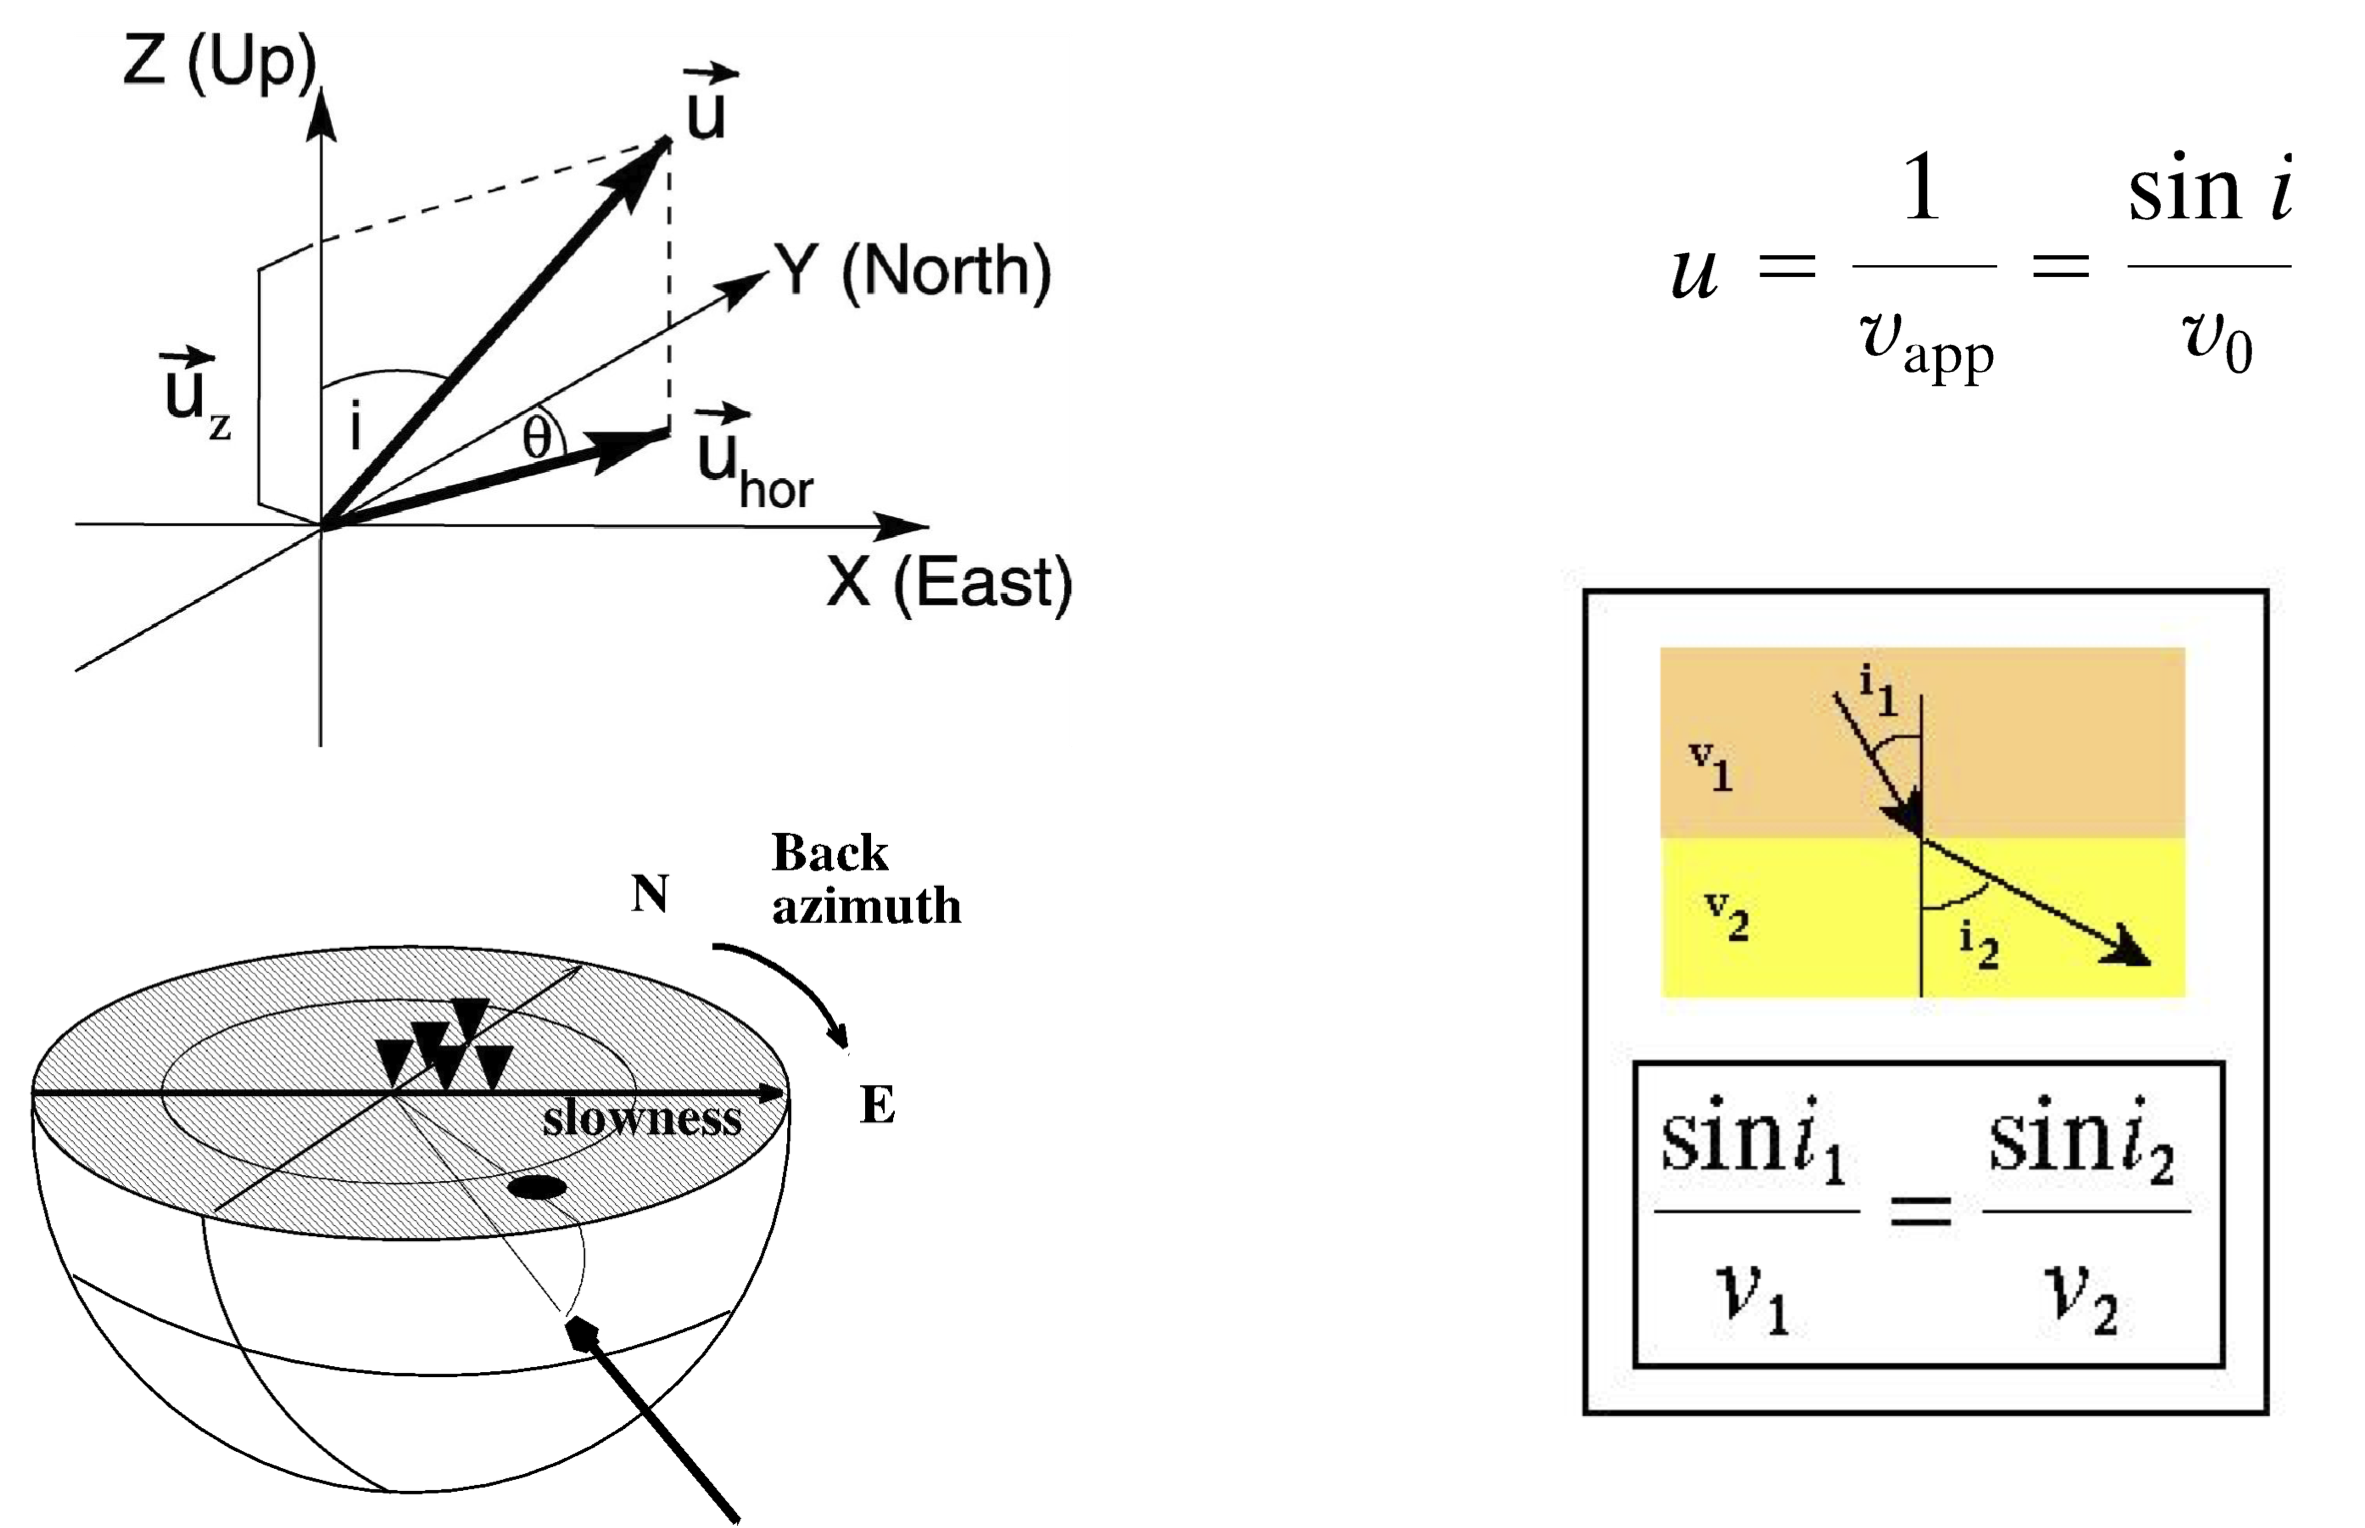

In [2]:
## import the requried the modules and functions
from pydsm.relab import shiftdim
import numpy as np
from obspy.clients.fdsn import Client 
from obspy import UTCDateTime
from obspy.core.stream import Stream
import matplotlib.pyplot as plt

## 1. Beamforming example of an ideal point souce
Here we test an ideal case, in which we have a point source, and two mini arrays. The arrays record the same signal exact the same as the point source (no geometry expanding, attenuation, no radiation pattern). And the medium is homogenous with P wave velocity 6 km/s. In this example, one array is already preset. You need to set another mini array to constrain the source location.  

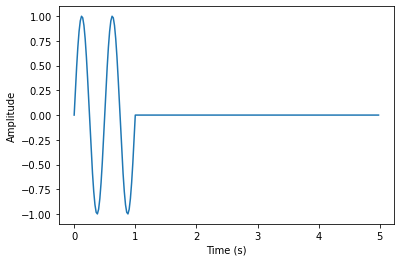

In [3]:
# source location & source signal
source_x = 0
source_y = 0
source_z = 7 
source_signal_length = 5 # in seconds
recSampInt = 0.02 #signal sample interval
recNumData = source_signal_length/recSampInt; # number of sample points
xtim = np.arange(0,recNumData*recSampInt-recSampInt,recSampInt) #time in second
freq= 2 #frequnecy in Hz
source_signal = np.sin(2*np.pi*freq*xtim)
source_signal[51:len(xtim)] = 0 #set the signal to be 1 second sine signal
plt.plot(xtim,source_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

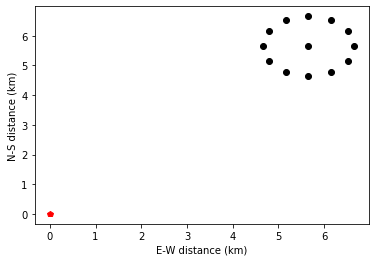

In [4]:
#array 1, in x-y, km
array1 = np.loadtxt("./array1.txt")
plt.plot(array1[:,0],array1[:,1],'ko')
plt.xlabel('E-W distance (km)')
plt.ylabel('N-S distance (km)')
plt.plot(source_x,source_y,'rp')
plt.show()

In [5]:
np.__version__

'1.21.5'

Nfft = 250.0
Nfft = 250


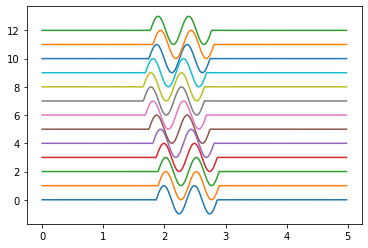

In [34]:
dt = recSampInt  # sampling interval
Fmax = 1/dt; # maximum frequency
Nfft = recNumData # number of samples in each chopped seismogram (i.e. number in fft)
print("Nfft = {}".format(Nfft))
Nfft = int(Nfft)
print("Nfft = {}".format(Nfft))

frq = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int64(Nfft/2+1)) #central frequencies
## p wave velocity
Vp = 6 # km/s
dis_h = np.zeros((array1.shape[0],1))
travelT1 = dis_h
## calculate the array signal, the signal is same as the source, only the start time is different
array_data = np.zeros((array1.shape[0],len(source_signal)))
vehlp = np.fft.fft(source_signal);
for ind1 in np.arange(array1.shape[0]):
    dis_h[ind1] = np.sqrt(array1[ind1,0]**2+array1[ind1,1]**2)
    ##travel time from the source to each station
    travelT1[ind1] = -1*np.sqrt(dis_h[ind1]**2+source_z**2)/Vp
    rep = np.exp(1j*2*np.pi*frq*travelT1[ind1])
    shft = shiftdim(vehlp[0:len(frq)],1,nargout=1) #shift in frequency domain
    dshft = rep.T*shft 
    #s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft))) # return no error for Bo?!
    s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
    array_data[ind1,:] = s_sh
    plt.plot(xtim,s_sh+ind1)

plt.show()

In [17]:
##preform beamforming using the synthetic array signals
acent=[np.mean(array1[:,0]), np.mean(array1[:,1])] #array center
##distance of each station to the array center
distE = array1[:,0] - acent[0] # NS offset in km
distN = array1[:,1] - acent[1] # EW offset in km
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;
beam=np.zeros([len(NsloV),len(EsloV)])

for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = source_signal*0
        for ind3 in np.arange(array1.shape[0]):
            vehlp = np.fft.fft(array_data[ind3,:])
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1) #shift in frequency domain
            dshft = rep.T*shft 
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft))) 
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
        beam[ind1,ind2] = np.sum((stdel/array1.shape[0])**2)

In [18]:
aspectratio = 1

Slowness [s/km] 0.127279
Back azimuth from North [degree] -135
-3.45512985522
-9.68400743494


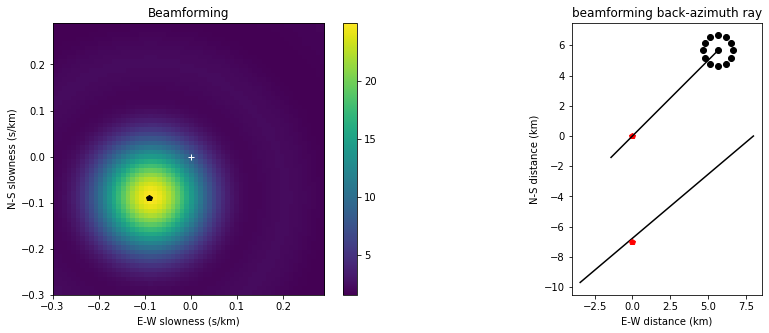

In [19]:
# find the slowness corresponding to the peak beam energy
indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)
beampeak = beam[indextuple]
beampeak_x = EsloV[indextuple[1]]
beampeak_y = NsloV[indextuple[0]]

##plot the beamforming results and the back-azimuth ray tracing
fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
bm = ax1.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax1.plot(beampeak_x,beampeak_x,'kp')
ax1.plot(0,0,'w+')
ax1.set_aspect(aspectratio)
ax1.set_xlabel('E-W slowness (s/km)')
ax1.set_ylabel('N-S slowness (s/km)')
ax1.set_title('Beamforming')
plt.colorbar(bm, ax=ax1)
print('Slowness [s/km] %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
print('Back azimuth from North [degree] %g'%(np.rad2deg(np.arctan2(beampeak_x,beampeak_y))))
ax2.plot(array1[:,0],array1[:,1],'ko')
ax2.plot(source_x,source_y,'rp')
## generate a 10 km backazimuth ray from the array center
backdis = 10
backaz = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))
end_x = backdis*np.sin(backaz/180*np.pi) + acent[0]
end_y = backdis*np.cos(backaz/180*np.pi) + acent[1]
plt.plot([acent[0],end_x],[acent[1],end_y],'k-')
ax2.set_xlabel('E-W distance (km)')
ax2.set_ylabel('N-S distance (km)')
ax2.set_title('beamforming back-azimuth ray')
aspectratio = 1.0
ratio_default=(ax2.get_xlim()[1]-ax2.get_xlim()[0])/(ax2.get_ylim()[1]-ax2.get_ylim()[0])
ax2.set_aspect(ratio_default*aspectratio)

## generate a 15 km slowness ray along the backazimuth projection from the array center
beam_slowness = np.sqrt(beampeak_x**2+beampeak_x**2);
incident_angle = np.rad2deg(np.arcsin(beam_slowness/(1/Vp)))
backdis_z = 15
back_incident = incident_angle+180
end_x = backdis_z*np.sin(back_incident/180*np.pi) + 8
end_z = backdis_z*np.cos(back_incident/180*np.pi) + 0
print(end_x)
print(end_z)
plt.plot([8,end_x],[0,end_z],'k-')
plt.plot(0,-7,'rp')

Slowness [s/km] 0.127279
Back azimuth from North [degree] -135


Text(0.5, 0, 'horizontal distance (km)')

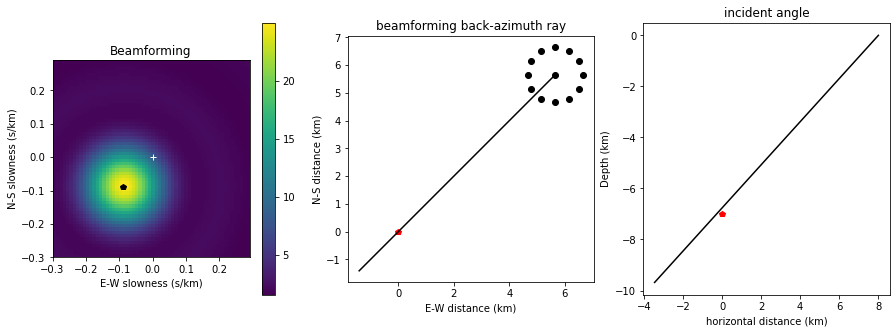

In [20]:
# find the slowness corresponding to the peak beam energy
indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)
beampeak = beam[indextuple]
beampeak_x = EsloV[indextuple[1]]
beampeak_y = NsloV[indextuple[0]]

##plot the beamforming results and the back-azimuth ray tracing
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,figsize=(15,5))
bm = ax1.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax1.plot(beampeak_x,beampeak_x,'kp')
ax1.plot(0,0,'w+')
ax1.set_aspect(aspectratio)
ax1.set_xlabel('E-W slowness (s/km)')
ax1.set_ylabel('N-S slowness (s/km)')
ax1.set_title('Beamforming')
plt.colorbar(bm, ax=ax1)
print('Slowness [s/km] %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
print('Back azimuth from North [degree] %g'%(np.rad2deg(np.arctan2(beampeak_x,beampeak_y))))
ax2.plot(array1[:,0],array1[:,1],'ko')
ax2.plot(source_x,source_y,'rp')
## generate a 10 km backazimuth ray from the array center
backdis = 10
backaz = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))
end_x = backdis*np.sin(backaz/180*np.pi) + acent[0]
end_y = backdis*np.cos(backaz/180*np.pi) + acent[1]
ax2.plot([acent[0],end_x],[acent[1],end_y],'k-')
ax2.set_xlabel('E-W distance (km)')
ax2.set_ylabel('N-S distance (km)')
ax2.set_title('beamforming back-azimuth ray')
aspectratio = 1.0
ratio_default=(ax2.get_xlim()[1]-ax2.get_xlim()[0])/(ax2.get_ylim()[1]-ax2.get_ylim()[0])
ax2.set_aspect(ratio_default*aspectratio)

## generate a 15 km slowness ray along the backazimuth projection from the array center
beam_slowness = np.sqrt(beampeak_x**2+beampeak_x**2);
incident_angle = np.rad2deg(np.arcsin(beam_slowness/(1/Vp)))
backdis_z = 15
back_incident = incident_angle+180
source_arraycenter_dis_h = np.sqrt((acent[0]-source_x)**2+(acent[1]-source_y)**2)
end_zx = backdis_z*np.sin(back_incident/180*np.pi)+ source_arraycenter_dis_h
end_zz = backdis_z*np.cos(back_incident/180*np.pi)

ax3.plot([source_arraycenter_dis_h*np.sin((backaz+180)/180*np.pi)/np.abs(np.sin((backaz+180)/180*np.pi)),end_zx],[0,end_zz],'k-')
ax3.plot(source_x,-1*source_z,'rp')
ax3.set_title('incident angle')
ax3.set_ylabel('Depth (km)')
ax3.set_xlabel('horizontal distance (km)')

## 2. Beamforming using real array data in southern CA
In this example, we use two mini arrays (GA and AZ) to do beamforming a small earthquake, and compare the beamforming location with the catalog location. 

/import/freenas-m-04-students/fkutschera/miniconda3/envs/python37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


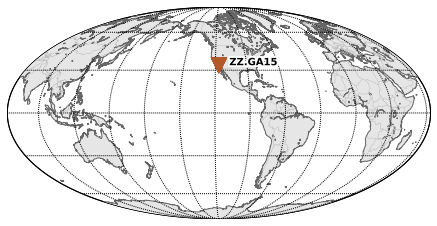

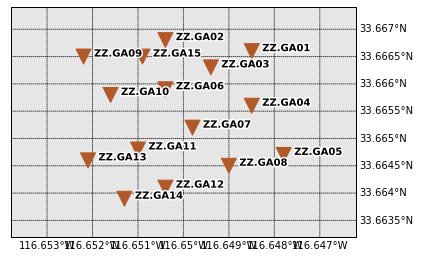

In [21]:
# set up the data client
c = Client("IRIS")
##an earthquakes in this time window, 2011/06/06 12:17:00.17 eq  l 0.81 l   33.65350 -116.71767  12.4 A 14996836   34  775
start=UTCDateTime("2011-06-06T12:17:00.000")
end=UTCDateTime("2011-06-06T12:17:10.000")
## Start with GA array
inv_check = c.get_stations(network="ZZ", station="GA*",channel="SHZ",
                                starttime=start,
                                endtime=end)
inv_check.plot() #plot the array location in global scale
inv_check.plot(projection="local"); #plot the array location in local scale

In [22]:
##get the array location and waveforms
sta=[]
GA_station_coordinates=[]
for network in inv_check:
    for station in network:
        ##station_coordinates.append((network.code, station.code, station.latitude, station.longitude, station.elevation))
        sta.append(station.code)
        GA_station_coordinates.append(( station.longitude,station.latitude))

acoor=np.array(GA_station_coordinates) ##get array locations in lon-lat
acent=[np.mean(acoor[:,0]), np.mean(acoor[:,1])] ##array center location in lon-lat

total_sta = len(sta) 
cha = 'SHZ' ##station channel
 
waveform = Stream()
## download the data, remove the instrument response
for num in np.arange(total_sta):
    inv = c.get_stations(network="ZZ",station=sta[num],location='',channel=cha,starttime=start,endtime=end,level='response')
    st = c.get_waveforms(network="ZZ",station=sta[num],location='',channel=cha,starttime=start,endtime=end)
    ## interpolate when there is a data gap
    st.merge(method=1,fill_value='interpolate',interpolation_samples=2)  ##Error unindent does not match any outer indentation level
    st.remove_response(inventory=inv,output='VEL')      
    st.detrend('simple')
    waveform += st   
    print('num: ', num)
    name = 'ZZ'+'.'+sta[num]+'..SHZ' 
    print(sta[num]+'-lon: ',inv.get_coordinates(name)['longitude'])
    print(sta[num]+'-lat: ',inv.get_coordinates(name)['latitude']) 
##find the common time base for the data           
starttime = max([tr.stats.starttime for tr in waveform])
endtime = min([tr.stats.endtime for tr in waveform])
waveform.trim(starttime,endtime,nearest_sample=True)

num:  0
GA01-lon:  -116.648499
GA01-lat:  33.666599
num:  1
GA02-lon:  -116.650398
GA02-lat:  33.666801
num:  2
GA03-lon:  -116.649399
GA03-lat:  33.666302
num:  3
GA04-lon:  -116.648499
GA04-lat:  33.6656
num:  4
GA05-lon:  -116.647797
GA05-lat:  33.6647
num:  5
GA06-lon:  -116.650398
GA06-lat:  33.665901
num:  6
GA07-lon:  -116.649803
GA07-lat:  33.665199
num:  7
GA08-lon:  -116.649002
GA08-lat:  33.664501
num:  8
GA09-lon:  -116.652199
GA09-lat:  33.6665
num:  9
GA10-lon:  -116.651604
GA10-lat:  33.665798
num:  10
GA11-lon:  -116.651001
GA11-lat:  33.664799
num:  11
GA12-lon:  -116.650398
GA12-lat:  33.664101
num:  12
GA13-lon:  -116.6521
GA13-lat:  33.6646
num:  13
GA14-lon:  -116.651299
GA14-lat:  33.663898
num:  14
GA15-lon:  -116.650902
GA15-lat:  33.6665


15 Trace(s) in Stream:
ZZ.GA01..SHZ | 2011-06-06T12:17:00.015000Z - 2011-06-06T12:17:09.990000Z | 40.0 Hz, 400 samples
ZZ.GA02..SHZ | 2011-06-06T12:17:00.005000Z - 2011-06-06T12:17:09.980000Z | 40.0 Hz, 400 samples
ZZ.GA03..SHZ | 2011-06-06T12:17:00.010000Z - 2011-06-06T12:17:09.985000Z | 40.0 Hz, 400 samples
ZZ.GA04..SHZ | 2011-06-06T12:17:00.010000Z - 2011-06-06T12:17:09.985000Z | 40.0 Hz, 400 samples
ZZ.GA05..SHZ | 2011-06-06T12:17:00.015000Z - 2011-06-06T12:17:09.990000Z | 40.0 Hz, 400 samples
ZZ.GA06..SHZ | 2011-06-06T12:17:00.015000Z - 2011-06-06T12:17:09.990000Z | 40.0 Hz, 400 samples
ZZ.GA07..SHZ | 2011-06-06T12:17:00.025000Z - 2011-06-06T12:17:10.000000Z | 40.0 Hz, 400 samples
ZZ.GA08..SHZ | 2011-06-06T12:17:00.020000Z - 2011-06-06T12:17:09.995000Z | 40.0 Hz, 400 samples
ZZ.GA09..SHZ | 2011-06-06T12:17:00.010000Z - 2011-06-06T12:17:09.985000Z | 40.0 Hz, 400 samples
ZZ.GA10..SHZ | 2011-06-06T12:17:00.020000Z - 2011-06-06T12:17:09.995000Z | 40.0 Hz, 400 samples
ZZ.GA11..SHZ | 20

In [23]:
print(waveform[0].stats)

               network: ZZ
               station: GA01
              location: 
               channel: SHZ
             starttime: 2011-06-06T12:17:00.015000Z
               endtime: 2011-06-06T12:17:09.990000Z
         sampling_rate: 40.0
                 delta: 0.025
                  npts: 400
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 4096})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2011, 6, 6, 12, 17, 9, 990000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 6, 6, 12, 16, 59, 990000))', "ObsPy 1.2.2: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fa188061748>::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level

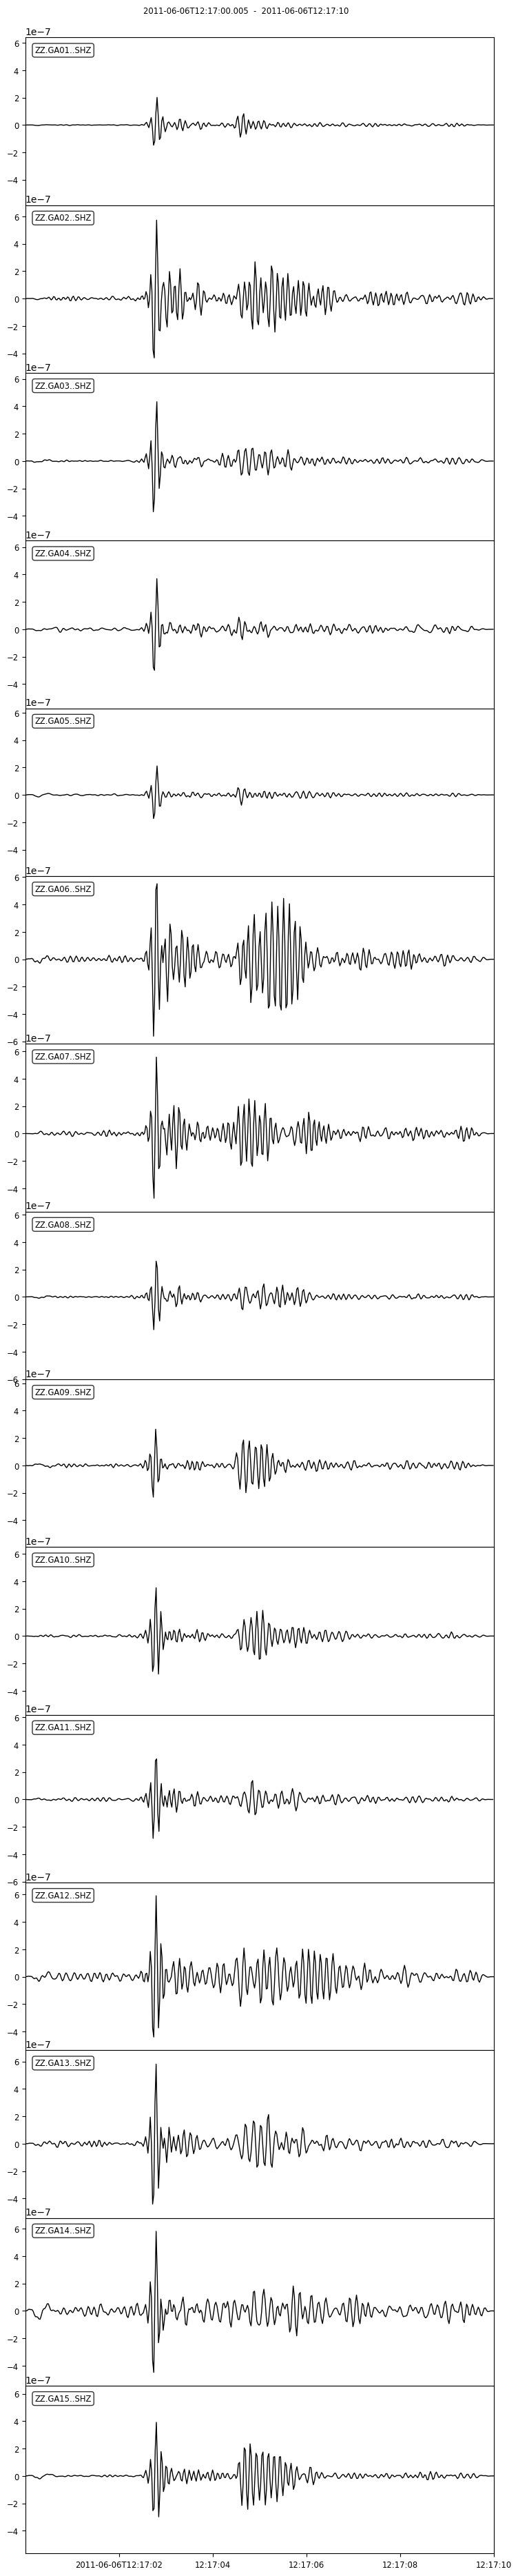

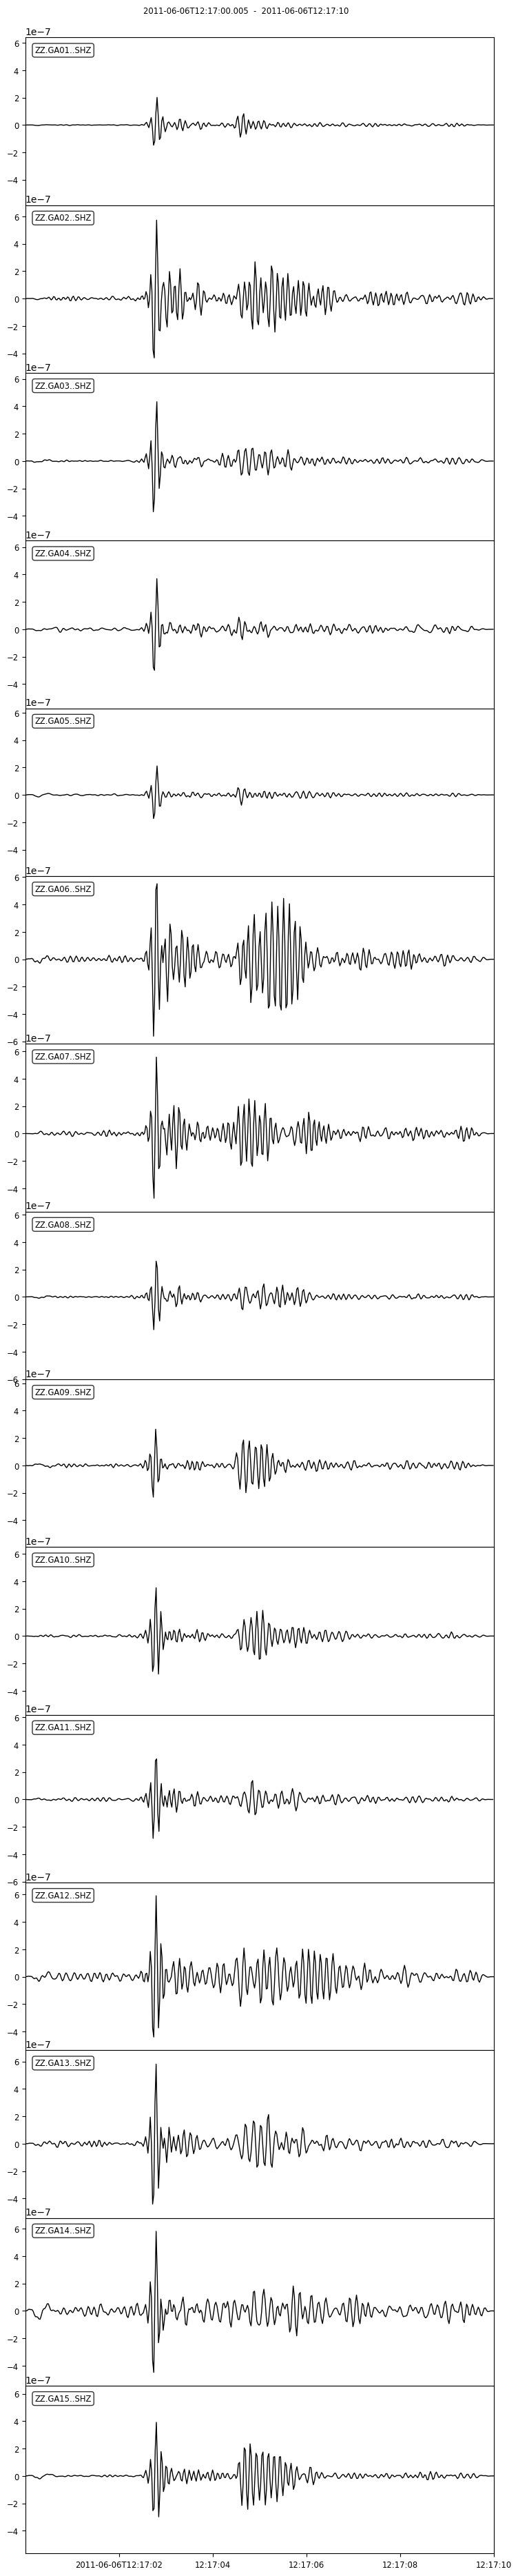

In [24]:
##resampling data to the same sampling rate and detrend, frequency filter the data
freq_resampling=40
freqmin_select=2
freqmax_select=10
waveform.resample(freq_resampling)
waveform.detrend('demean')
waveform.filter('bandpass', freqmin=freqmin_select, freqmax=freqmax_select, corners=4, zerophase=True)
waveform.taper(max_percentage = 0.05)
waveform.plot()

In [25]:
##Cut a time window around the P wave to do beamforming
waveform1 = waveform.copy()
waveform1.trim(UTCDateTime("2011-06-06T12:17:02.000"),UTCDateTime("2011-06-06T12:17:04.000"),nearest_sample=True)
#waveform1.trim(UTCDateTime("2011-06-06T12:17:00.100"),UTCDateTime("2011-06-06T12:17:02.000"),nearest_sample=True)
sp_num=len(waveform1[0].data)
test_data=np.zeros([sp_num,len(waveform1)])
for ind in np.arange(len(waveform1)):
    test_data[:,ind]=waveform1[ind].data


In [26]:
##run beamforming
dt=waveform1[0].stats.delta  ## sampling interval
Fmax=np.int(1/dt); ## maximum frequency
Nfft = waveform1[0].stats.npts ## number of sample in each chopped seismogram (i.e. number in fft)
frq = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)); ## central frequencies

distN = (acoor[:,1] - acent[1])*111.0; # NS offset in km
distE = (acoor[:,0] - acent[0])*111.0*np.cos(acent[1]/180*np.pi) ## cos(acent(2)*pi/180); % EW offset in km

## Slowness domain
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;
beam=np.zeros([len(EsloV),len(NsloV)])

for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = np.zeros([len(test_data)])
        for ind3 in np.arange(acoor.shape[0]):
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            vehlp = np.fft.fft(test_data[:,ind3])
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1)
            dshft = rep.T*shft
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
        beam[ind1,ind2] = np.sum((stdel/acoor.shape[0])**2)

# find peak
indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)
beampeak = beam[indextuple]
beampeak_x = EsloV[indextuple[1]]
beampeak_y = NsloV[indextuple[0]]
backaz_GA = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))

/import/freenas-m-04-students/fkutschera/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/import/freenas-m-04-students/fkutschera/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing 

Slowness [s/km] 0.0848528
Back azimuth from North [degree] -123.69


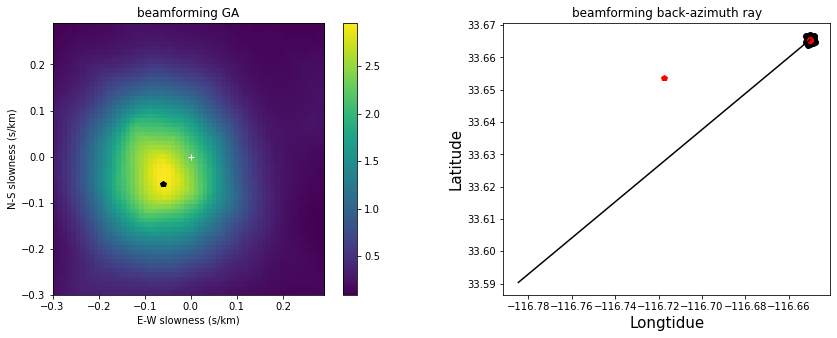

In [27]:
##plot the beamforming results and do back-azimuth tracing from the array center
import geopy
import geopy.distance
fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
bm = ax1.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax1.plot(beampeak_x,beampeak_x,'kp')
ax1.plot(0,0,'w+')
ax1.set_aspect(1)
ax1.set_xlabel('E-W slowness (s/km)')
ax1.set_ylabel('N-S slowness (s/km)')
ax1.set_title('beamforming GA')
plt.colorbar(bm, ax=ax1)
print('Slowness [s/km] %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
print('Back azimuth from North [degree] %g'%(np.rad2deg(np.arctan2(beampeak_x,beampeak_y))))

ax2.plot(acoor[:,0],acoor[:,1],'ko')
ax2.plot(acent[0],acent[1],'ro')
##Add event location
ax2.plot(-116.71767,33.65350,'rp')
##Add 15 km backazimuth ray tracing in surface from the array center
# Define starting point, array center
backaz_dis = 15
start = geopy.Point(acent[1], acent[0])
# Define a general distance object, initialized with a distance of 15 km.
d = geopy.distance.distance(kilometers = backaz_dis)

# Use the `destination` method with a bearing of backazimuth degrees (which is north)
# in order to go from point `start` 15 km to north.
A=d.destination(point=start, bearing = backaz_GA)
endpoint = [A[0], A[1]]
ax2.plot([acent[0],A[1]],[acent[1],A[0]],'k-')
plt.xlabel('Longtidue',fontsize=15)
plt.ylabel('Latitude',fontsize=15)
ax2.set_xlabel('Longtidue')
ax2.set_ylabel('Latitude')
ax2.set_title('beamforming back-azimuth ray')
aspectratio = 1.0*np.cos(acent[1]/180*np.pi)
ratio_default=(ax2.get_xlim()[1]-ax2.get_xlim()[0])/(ax2.get_ylim()[1]-ax2.get_ylim()[0])
ax2.set_aspect(ratio_default*aspectratio)

num:  0
AZ01-lon:  -116.651001
AZ01-lat:  33.513302
num:  1
AZ05-lon:  -116.651001
AZ05-lat:  33.514999
num:  2
AZ07-lon:  -116.650398
AZ07-lat:  33.515999
num:  3
AZ08-lon:  -116.649597
AZ08-lat:  33.516701
num:  4
AZ09-lon:  -116.648598
AZ09-lat:  33.516499
num:  5
AZ10-lon:  -116.648201
AZ10-lat:  33.5158
num:  6
AZ11-lon:  -116.6493
AZ11-lat:  33.5158
num:  7
AZ13-lon:  -116.6492
AZ13-lat:  33.5145
num:  8
AZ14-lon:  -116.649498
AZ14-lat:  33.513599
num:  9
AZ15-lon:  -116.6502
AZ15-lat:  33.514301


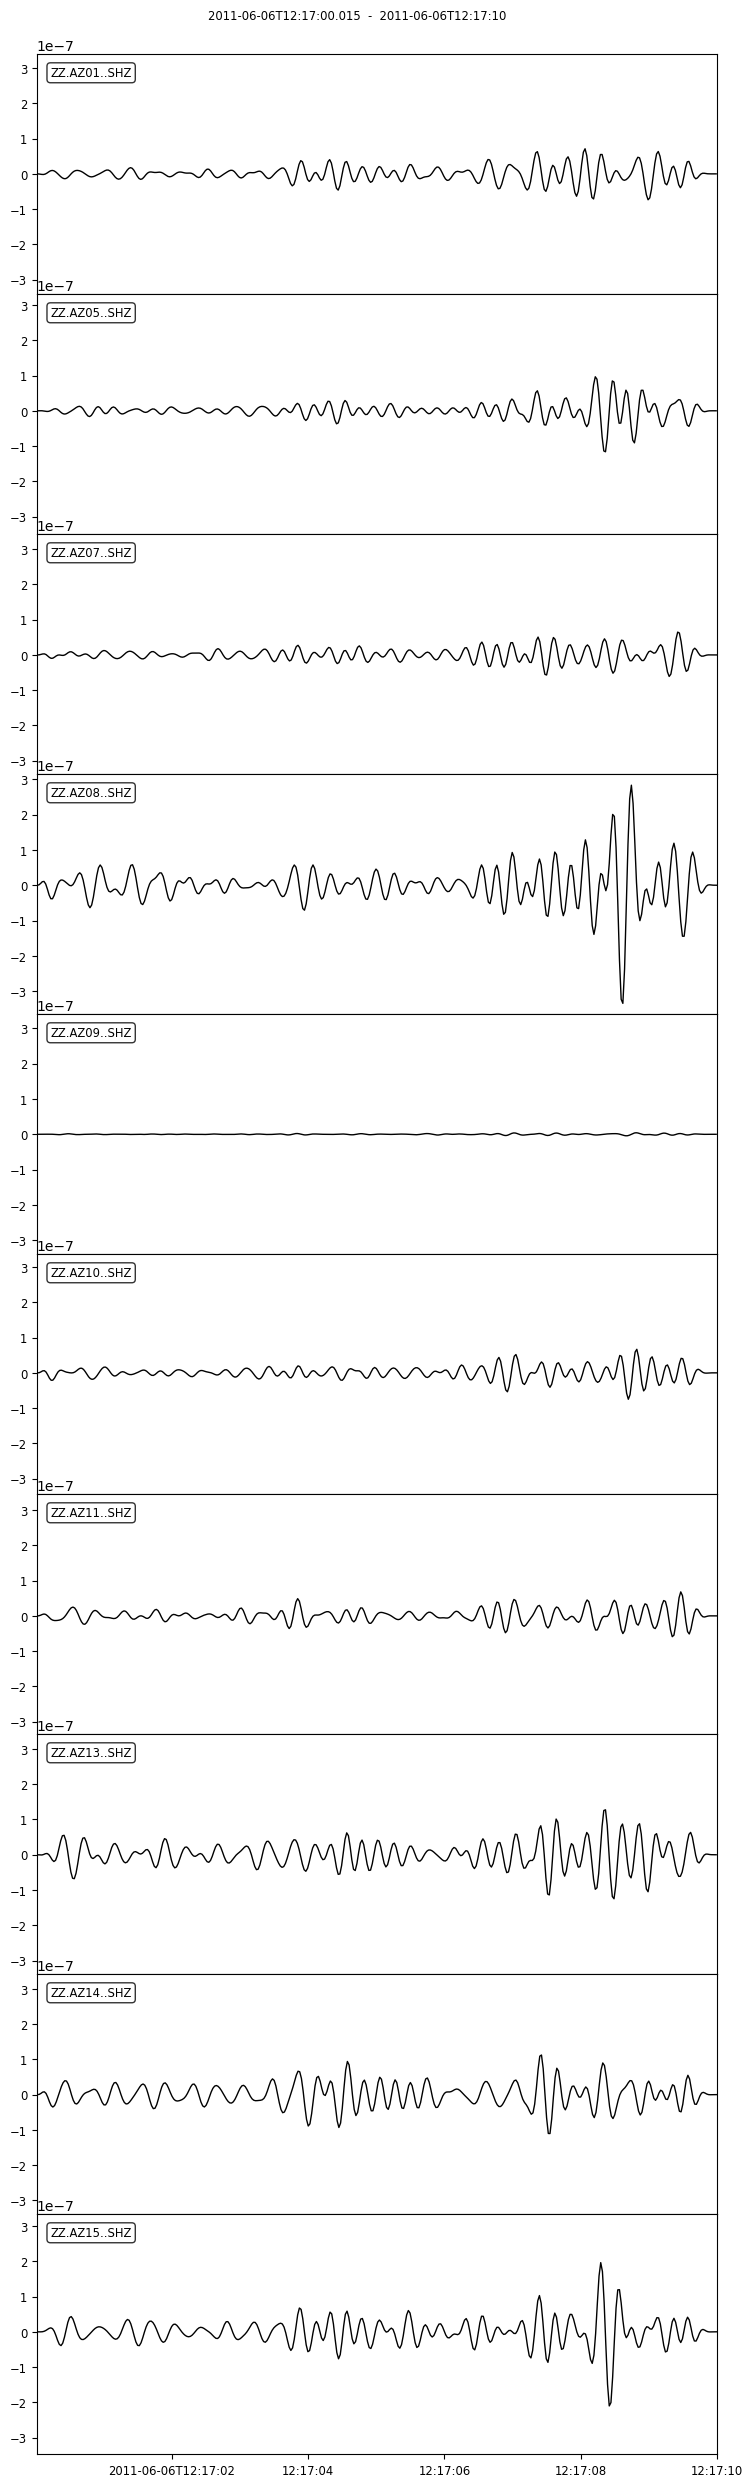

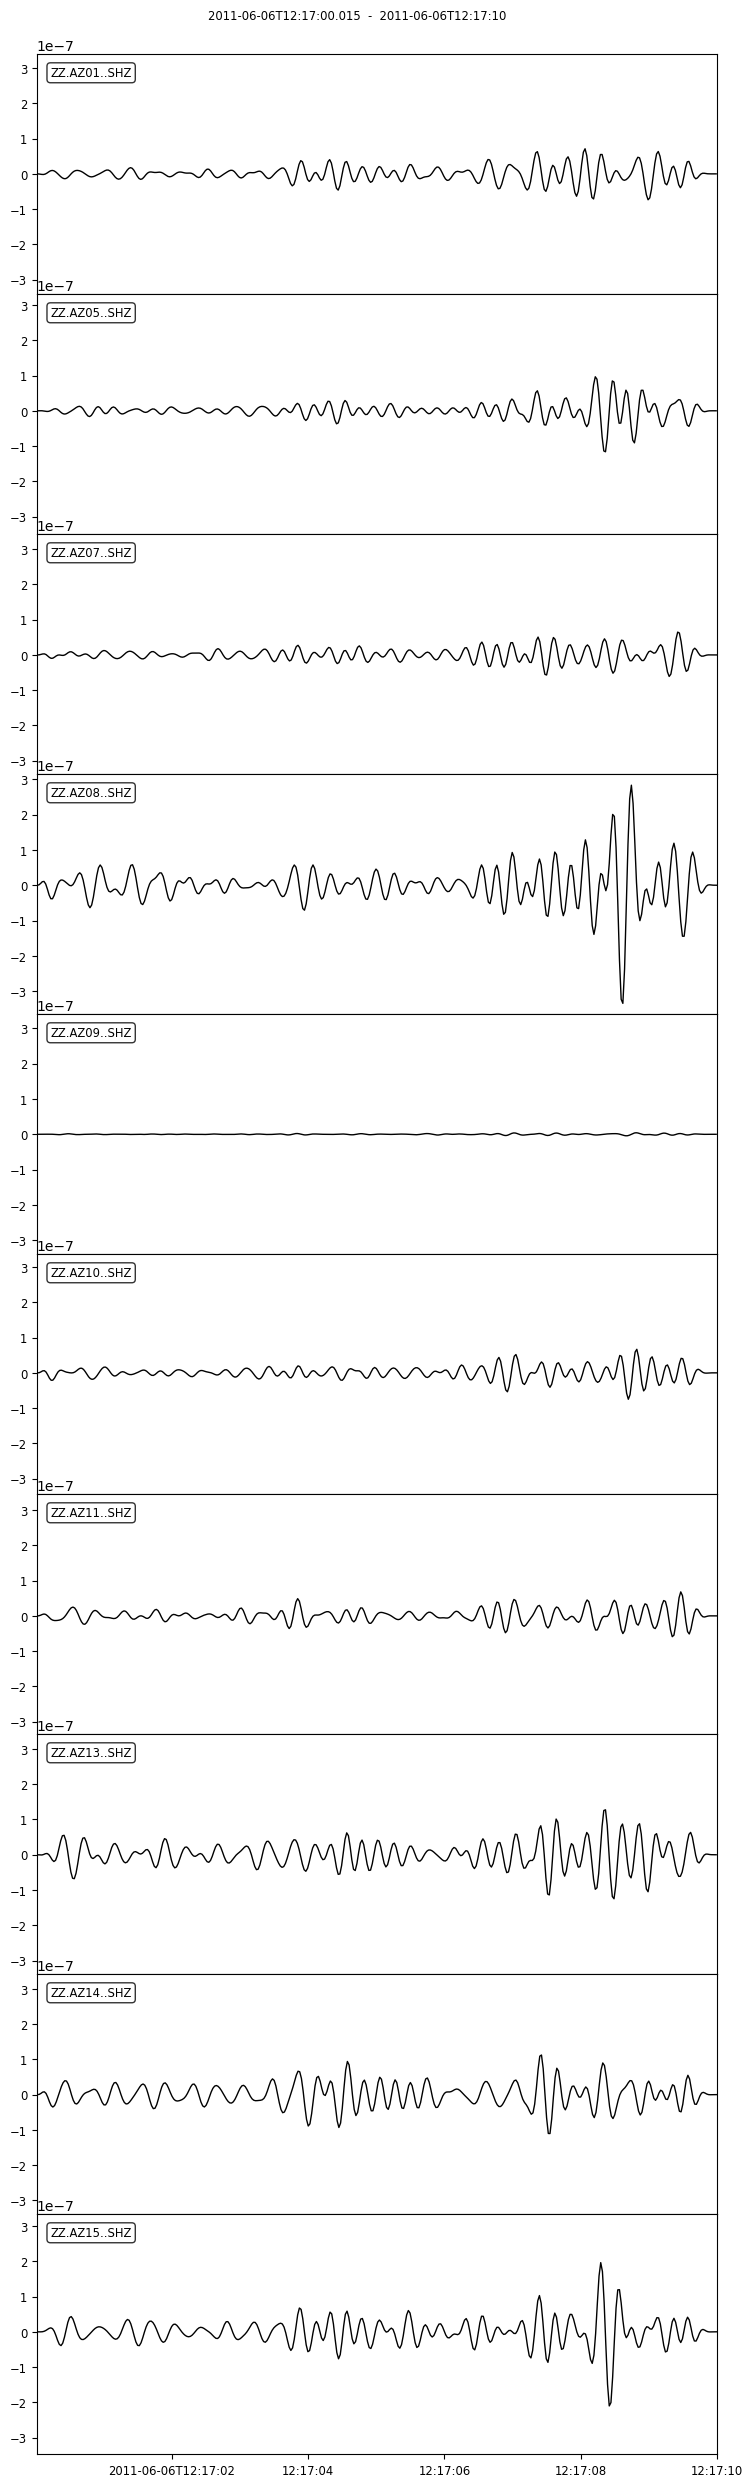

In [28]:
##beamforming using AZ array
##in this case,we list the stations, since some stations are in operation during the time period, but no data available
start=UTCDateTime("2011-06-06T12:17:00.000")
end=UTCDateTime("2011-06-06T12:17:10.000")
sta_az=(['AZ01', 'AZ05', 'AZ07', 'AZ08', 'AZ09', 'AZ10', 'AZ11', 'AZ13', 'AZ14', 'AZ15'])     
total_sta_az = len(sta_az) 
cha = 'SHZ'
waveform = Stream()
acoor_az = np.zeros([len(sta_az),2])
for num in np.arange(total_sta_az):
    inv = c.get_stations(network="ZZ",station=sta_az[num],location='',channel=cha,starttime=start,endtime=end,level='response')
    st = c.get_waveforms(network="ZZ",station=sta_az[num],location='',channel=cha,starttime=start,endtime=end)
    st.merge(method=1,fill_value='interpolate',interpolation_samples=2)  ##Error unindent does not match any outer indentation level
    st.remove_response(inventory=inv,output='VEL')    
    st.detrend('simple')
    waveform += st
    
    print('num: ', num)
    name = 'ZZ'+'.'+sta_az[num]+'..SHZ' 
    print(sta_az[num]+'-lon: ',inv.get_coordinates(name)['longitude'])
    print(sta_az[num]+'-lat: ',inv.get_coordinates(name)['latitude']) 
    acoor_az[num,0]=np.double(inv.get_coordinates(name)['longitude'])
    acoor_az[num,1]=np.double(inv.get_coordinates(name)['latitude'])
acent_az=[np.mean(acoor_az[:,0]), np.mean(acoor_az[:,1])]           
starttime = max([tr.stats.starttime for tr in waveform])
endtime = min([tr.stats.endtime for tr in waveform])
waveform.trim(starttime,endtime,nearest_sample=True)
freq_resampling=40
freqmin_select=2
freqmax_select=5
waveform.resample(freq_resampling)
waveform.detrend('demean')
waveform.filter('bandpass', freqmin=freqmin_select, freqmax=freqmax_select, corners=4, zerophase=True)
waveform.taper(max_percentage = 0.05)
waveform.plot()

In [29]:
##beamforming of AZ array
waveform1 = waveform.copy()
##select the time window for beamforming
waveform1.trim(UTCDateTime("2011-06-06T12:17:03.000"),UTCDateTime("2011-06-06T12:17:05.000"),nearest_sample=True)
#waveform1[0].stats ##check the headers in the waveform
sp_num=len(waveform1[0].data)
test_data=np.zeros([sp_num,len(waveform1)])
for ind in np.arange(len(waveform1)):
    test_data[:,ind]=waveform1[ind].data

dt=waveform1[0].stats.delta  ## sampling interval
Fmax=np.int(1/dt); ## maximum frequency
Nfft = waveform1[0].stats.npts ## number of sample in each chopped seismogram (i.e. number in fft)
frq = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)); ## central frequencies

distN = (acoor_az[:,1] - acent_az[1])*111.0; # NS offset in km
distE = (acoor_az[:,0] - acent_az[0])*111.0*np.cos(acent_az[1]/180*np.pi) ## cos(acent(2)*pi/180); % EW offset in km

## Slowness domain
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;

beam=np.zeros([len(EsloV),len(NsloV)])
for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = np.zeros([len(test_data)])
        for ind3 in np.arange(acoor_az.shape[0]):
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            vehlp = np.fft.fft(test_data[:,ind3])
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1)
            dshft = rep.T*shft
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
            beam[ind1,ind2] = np.sum((stdel/acoor_az.shape[0])**2)

# find peak
indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)
beampeak = beam[indextuple]
beampeak_x = EsloV[indextuple[1]]
beampeak_y = NsloV[indextuple[0]]
backaz_AZ = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))


/import/freenas-m-04-students/fkutschera/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/import/freenas-m-04-students/fkutschera/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int

Slowness [s/km] 0.0848528
Back azimuth from North [degree] -24.7751


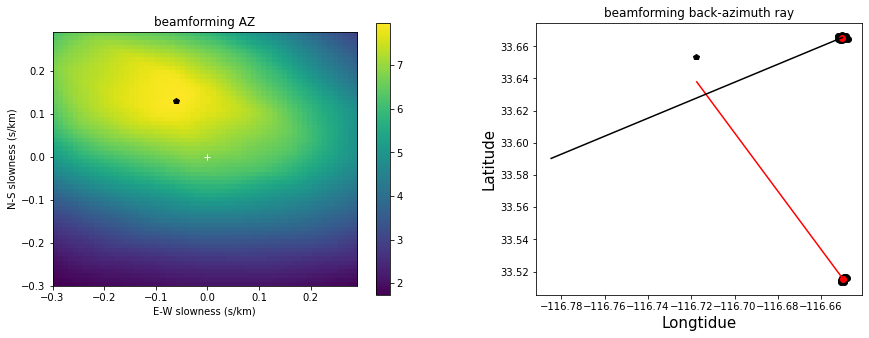

In [30]:
fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
bm = ax1.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax1.plot(beampeak_x,beampeak_y,'kp')
ax1.plot(0,0,'w+')
ax1.set_aspect(aspectratio)
ax1.set_xlabel('E-W slowness (s/km)')
ax1.set_ylabel('N-S slowness (s/km)')
ax1.set_title('beamforming AZ')
plt.colorbar(bm, ax=ax1)
print('Slowness [s/km] %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
print('Back azimuth from North [degree] %g'%(np.rad2deg(np.arctan2(beampeak_x,beampeak_y))))

##plot backazimuth ray tracing from AZ array
ax2.plot(acoor_az[:,0],acoor_az[:,1],'ko')
ax2.plot(acent_az[0],acent_az[1],'ro')
##Add event location
ax2.plot(-116.71767,33.65350,'kp')
##Add backazimuth ray tracing in surface from the array center
# Define starting point, array center
start_az = geopy.Point(acent_az[1], acent_az[0])
# Define a general distance object, initialized with a distance of 10 km.
d_az = geopy.distance.distance(kilometers = 15)

# Use the `destination` method with a bearing of backazimuth degrees (which is north)
# in order to go from point `start` 5 km to north.
A_az=d_az.destination(point=start_az, bearing = backaz_AZ)
endpoint_az = [A_az[0], A_az[1]]
ax2.plot([acent_az[0],A_az[1]],[acent_az[1],A_az[0]],'r-')

##plot backazimuth ray tracing from GA array
ax2.plot(acoor[:,0],acoor[:,1],'ko')
ax2.plot(acent[0],acent[1],'ro')
ax2.plot([acent[0],A[1]],[acent[1],A[0]],'k-')

plt.xlabel('Longtidue',fontsize=15)
plt.ylabel('Latitude',fontsize=15)
ax2.set_xlabel('Longtidue')
ax2.set_ylabel('Latitude')
ax2.set_title('beamforming back-azimuth ray')
aspectratio = 1.0*np.cos(acent_az[1]/180*np.pi)
ratio_default=(ax2.get_xlim()[1]-ax2.get_xlim()[0])/(ax2.get_ylim()[1]-ax2.get_ylim()[0])
ax2.set_aspect(ratio_default*aspectratio)

In [31]:
np.__version__

'1.21.5'